In [5]:
import pickle
from pathlib import Path

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

DATA_DIR = Path("data")
FIGURES_DIR = Path("figures")

# Configurando o tamanho das fontes globalmente
plt.rcParams.update({
    'font.size': 14,          # Tamanho padrão da fonte
    'axes.titleweight': 'bold',  # Peso da fonte no título do gráfico
    'axes.titlesize': 16,     # Tamanho do título do gráfico
    'axes.labelsize': 14,     # Tamanho dos rótulos dos eixos
    'xtick.labelsize': 12,    # Tamanho das etiquetas no eixo X
    'ytick.labelsize': 12,    # Tamanho das etiquetas no eixo Y
    'legend.fontsize': 12,    # Tamanho da fonte na legenda
    'legend.title_fontsize': 14  # Tamanho do título da legenda
})

## Functions

In [6]:
def load_data(bench_data: Path) -> tuple[pd.DataFrame, dict]:
    try:
        with bench_data.open("rb") as data:
            bench_dict = pickle.load(data)
            metadata = bench_dict["metadata"]
            df = pd.DataFrame(bench_dict["dataframe"]).T.drop_duplicates().T
            print(df.head())
            return df, metadata
    except Exception as e:
        print(f"Error trying to open file {bench_data}: {e}")

def aggregate_data(df, by_columns:list[str]):
    # Group by 'Lookups' and calculate mean and std for 'Runtime'
    aggregated_df = df.groupby(by_columns).agg(
        runtime_mean=('time', 'mean'),
        runtime_std=('time', 'std'),
    ).reset_index()
    
    return aggregated_df

In [7]:
# XSBENCH MPICH+OFI+32VCI
df, metadata = load_data(DATA_DIR/"bench_metadata.pkl")
agg_df = aggregate_data(df, ['nodes'])

agg_df.head()

    name nodes       time
0  rhodo     1  45.441779
1  rhodo     1  44.762212
2  rhodo     1  44.492504
3  rhodo     1  44.652525
4  rhodo     1  50.178489


,nodes,runtime_mean,runtime_std
0,1,47.486475,2.644091
1,2,39.822439,7.217143
2,4,31.285371,6.065136
3,8,26.27556,0.541648


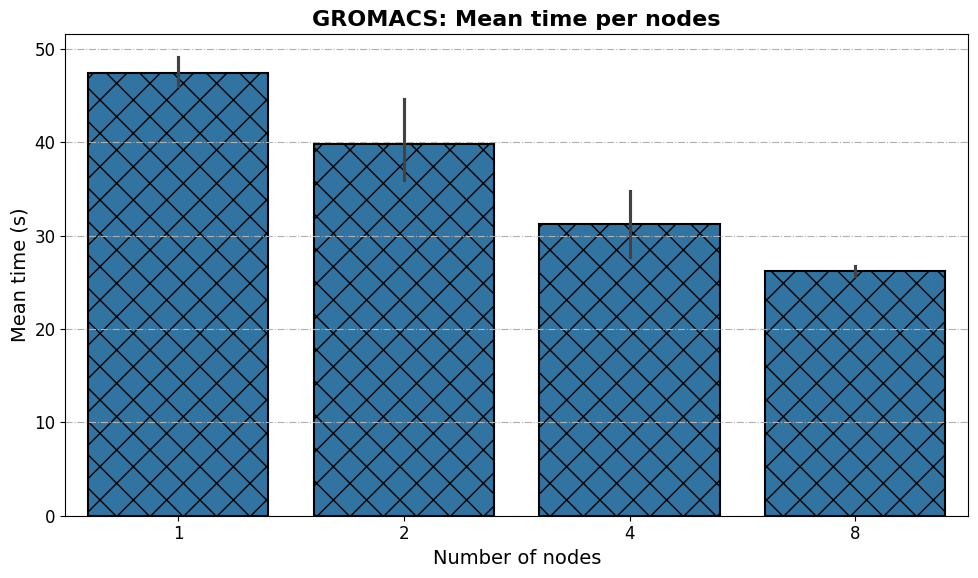

In [8]:
def plot_aggregated_by_nodes(df, title, output_file):
    # Aggregate data by 'nodes' and calculate mean of 'time'
    aggregated_df = df.groupby('nodes').agg(
        time_mean=('time', 'mean')
    ).reset_index()

    # Plot the bar plot
    plt.figure(figsize=(10, 6))
    bar_plot = sns.barplot(
        data=df,
        x='nodes',
        y='time',
        errorbar=("ci", 95),
        estimator="mean",
        # palette='tab10',
        edgecolor='black'
    )

    # Apply hatches to the bars
    hatches = ['x', '*', '+', 'o']
    for i, patch in enumerate(bar_plot.patches):
        # hatch = hatches[i % len(hatches)]
        hatch = 'x'
        patch.set_edgecolor('black')
        patch.set_linewidth(1.5)
        patch.set_hatch(hatch)

    # Customization
    plt.title(title)
    plt.xlabel('Number of nodes')
    plt.ylabel('Mean time (s)')
    plt.grid(True, axis='y', linestyle="-.")
    plt.tight_layout()

    # Save the figure
    plt.savefig(FIGURES_DIR/output_file)

# Example usage:
# plot_aggregated_by_nodes(df, "Mean Time by Nodes", "mean_time_by_nodes.png")
plot_aggregated_by_nodes(df, "GROMACS: Mean time per nodes", "output.pdf")